<a href="https://colab.research.google.com/github/Harm1995/CTA-sensitivity/blob/master/TS_distribution_alt_ana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The packages

In [ ]:
try:
  import iminuit
  from iminuit import Minuit

except:
  !pip install iminuit

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
import scipy
from scipy.stats import norm
import astropy
from astropy.io import fits
import seaborn as sns
import time
from tqdm.auto import tqdm, trange




time = 1

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
roi = 5                       ## Our range of interest in degrees
TeV = 10**-6                  ## Convertion rate
energy_start_bin = 3
offset = 0                    ## The offset of the telescope. We assume we look at the target directly
pre_normalisation = 1
energy_bin = 0

parsec = 3.08567758 * 10**18
Sun_to_centrum = 8122 * parsec

In [ ]:
## The Energy is saved as a tuple, via this way we make it a normal list

ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"
energy_list1 = np.array(fits.getdata(ring_path + 'ics_ring_1.fits', ext=1))
energies = []
for energy in energy_list1:
    E = float(str(energy)[1:-2])
    energies.append(E)
energies = np.array(energies)
energies = energies * TeV   


# Data

## Convolved data

In [ ]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'

orig_shape = (9, 47, 20, 20)
original_file = files_paths + 'Model_new.txt.txt'
simulated_backgrounds = np.loadtxt(original_file).reshape(orig_shape)

ics_rings = np.loadtxt(files_paths + 'ice_file.txt').reshape(4,46,20,20)
gce_rings = np.loadtxt(files_paths + 'gce_file.txt').reshape(4,46,20,20)
gce2_rings = np.loadtxt(files_paths + 'gce2_file.txt').reshape(4,46,20,20)
NB_rings = np.loadtxt(files_paths + 'NB_file.txt').reshape(5,46,20,20)
F98_rings = np.loadtxt(files_paths + 'F98_file.txt').reshape(5,46,20,20)
signal_rings = np.loadtxt(files_paths + 'signal_file.txt').reshape(5,46,20,20)
alternative_gce = np.loadtxt(files_paths + 'Alternative_gce.txt').reshape(10,46,20,20)
fermi_maps = np.loadtxt(files_paths + 'fermi_map').reshape(2,46,20,20)
fermi_bubble = simulated_backgrounds[-1][:-1] * 137
dark_matter_map = np.loadtxt(files_paths + 'dark_matter_map').reshape(46,20,20)


signal_inj_list = signal_rings
all_backgrounds = np.array([ics_rings[0], ics_rings[1], ics_rings[2], ics_rings[3], gce_rings[0], gce_rings[1], gce_rings[2], gce_rings[3],fermi_bubble])


We have the following Background Count maps

* 4 rings of ics maps 46 * 20 * 20
* 4 rings of GCE maps 46 * 20 * 20
* 2 Fermi maps 46 * 20 * 20


And for the alternative model:


* 4 ring maps H1 46 * 40 * 40
* 4 ring maps H2 46 * 40 * 40
* 4 rings of ics 46 * 20 * 20
* 2 dust maps 46 * 20 * 20
* 2 Fermi maps 46 * 20 * 20

And the Following signal - maps:

* 5  injection spectra NB signal map 46 * 20 * 20
* 5  injection spectra F98 map 46 * 20 * 20

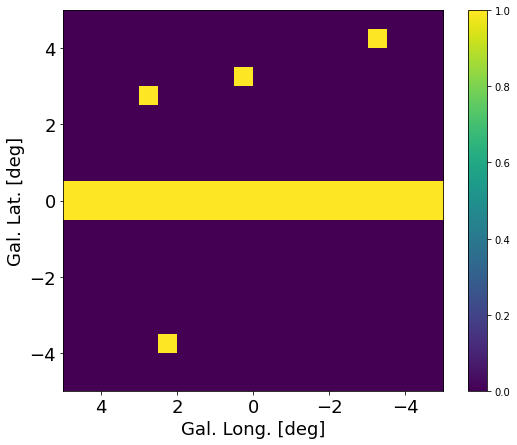

In [ ]:
pre_path = "/content/drive/My Drive/Colab Notebooks/master_project/"

def mask_matrix_fu():

  catalog = fits.open(pre_path + 'gll_psch_v13.fit')

  ptsrc_long = []
  ptsrc_lat = []

  # Here is load all the point sources in our range of interest:
  for i in range(len(catalog[1].data)):
      if(catalog[1].data[i][9] > 4.0 and catalog[1].data[i][33] == ''):
          if(-roi + 180 <= catalog[1].data[i][3] <= roi + 180):
              if(-roi <= catalog[1].data[i][4] <= roi):
                  ptsrc_long.append(catalog[1].data[i][3])
                  ptsrc_lat.append(catalog[1].data[i][4])

  # Here I make a matrix that has a zero on all the positions that are +/- 0.25 degrees away from
  # a Fermi high energy source. Also the galactic ridge (+/- 0.3 degrees lattitude) are maskt.
  mask_matrix = []
  y_coor = 0
  x_min = 180 - roi
  x_max = 180 + roi
  y_min = - roi
  y_max = roi
  y_steps = 4 * roi
  x_steps = 4 * roi

  for y in np.linspace(y_max, y_min, y_steps):
      mask_matrix.append([])
      for x in np.linspace(x_min, x_max, x_steps):
          mark = 0
          for i in range(len(ptsrc_long)):
              ps_x = ptsrc_long[i]
              ps_y = ptsrc_lat[i]
              if abs(ps_x - x) < 0.25:
                  if abs(ps_y - y) < 0.25:
                      mark = 1
                      break
  #            if ((ps_x - x)**2 + (ps_y - y)**2)**0.5  < 0.25:
  #                mark = 0
          if abs(y) < 0.3:
              mark = 1
          mask_matrix[y_coor].append(mark)
      y_coor += 1

  mask_matrix = np.array(mask_matrix)
  return mask_matrix

mask_matrix = mask_matrix_fu()






mask2 = []

for i in range(11):
  mask2.append(mask_matrix)

mask2 = np.array(mask2)

plt.figure(figsize=(9,7))
plt.xlabel("Gal. Long. [deg]",fontsize=18)
plt.ylabel("Gal. Lat. [deg]",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.imshow(mask2[0], extent = [roi,-roi,-roi,roi])
plt.colorbar()
plt.show()

## Compressing again to 11 rings

In [ ]:
Ics_ring_1_template = []
Ics_ring_2_template = []
Ics_ring_3_template = []
Ics_ring_4_template = []
GCE_ring_1_template = []
GCE_ring_2_template = []
GCE_ring_3_template = []
GCE_ring_4_template = []

fermi_template = []

signal_0_template = []
signal_1_template = []
signal_2_template = []
signal_3_template = []
signal_4_template = []


H1_ring_1_template = []
H1_ring_2_template = []
H1_ring_3_template = []
H1_ring_4_template = []

H2_ring_1_template = []
H2_ring_2_template = []
H2_ring_3_template = []
H2_ring_4_template = []

dust_pos_template = []
dust_neg_template = []

dark_matter_template = []

new_energies = []

for j in range(0,11):
  i = 2+j*4
  new_energies.append(energies[i])


  Ics_ring_1_template.append(np.sum(ics_rings[0][i:i+4], axis = 0))
  Ics_ring_2_template.append(np.sum(ics_rings[1][i:i+4], axis = 0))
  Ics_ring_3_template.append(np.sum(ics_rings[2][i:i+4], axis = 0))
  Ics_ring_4_template.append(np.sum(ics_rings[3][i:i+4], axis = 0))

  GCE_ring_1_template.append(np.sum(gce_rings[0][i:i+4], axis = 0))
  GCE_ring_2_template.append(np.sum(gce_rings[1][i:i+4], axis = 0))
  GCE_ring_3_template.append(np.sum(gce_rings[2][i:i+4], axis = 0))
  GCE_ring_4_template.append(np.sum(gce_rings[3][i:i+4], axis = 0))

  fermi_template.append(np.sum(fermi_maps[0][i:i+4], axis = 0))

  signal_0_template.append(np.sum(signal_rings[0][i:i+4], axis = 0))
  signal_1_template.append(np.sum(signal_rings[1][i:i+4], axis = 0))
  signal_2_template.append(np.sum(signal_rings[2][i:i+4], axis = 0))
  signal_3_template.append(np.sum(signal_rings[3][i:i+4], axis = 0))
  signal_4_template.append(np.sum(signal_rings[4][i:i+4], axis = 0))

  dark_matter_template.append(np.sum(dark_matter_map[i:i+4], axis = 0))


  H1_ring_1_template.append(np.sum(alternative_gce[0][i:i+4], axis = 0))
  H1_ring_2_template.append(np.sum(alternative_gce[1][i:i+4], axis = 0))
  H1_ring_3_template.append(np.sum(alternative_gce[2][i:i+4], axis = 0))
  H1_ring_4_template.append(np.sum(alternative_gce[3][i:i+4], axis = 0))

  H2_ring_1_template.append(np.sum(alternative_gce[4][i:i+4], axis = 0))
  H2_ring_2_template.append(np.sum(alternative_gce[5][i:i+4], axis = 0))
  H2_ring_3_template.append(np.sum(alternative_gce[6][i:i+4], axis = 0))
  H2_ring_4_template.append(np.sum(alternative_gce[7][i:i+4], axis = 0))

  dust_pos_template.append(np.sum(alternative_gce[8][i:i+4], axis = 0))
  dust_neg_template.append(np.sum(alternative_gce[9][i:i+4], axis = 0))



Ics_ring_1_template = np.array(Ics_ring_1_template)
Ics_ring_2_template = np.array(Ics_ring_2_template)
Ics_ring_3_template = np.array(Ics_ring_3_template)
Ics_ring_4_template = np.array(Ics_ring_4_template)
GCE_ring_1_template = np.array(GCE_ring_1_template)
GCE_ring_2_template = np.array(GCE_ring_2_template)
GCE_ring_3_template = np.array(GCE_ring_3_template)
GCE_ring_4_template = np.array(GCE_ring_4_template)

fermi_template = np.array(fermi_template)

signal_0_template = np.array(signal_0_template)
signal_1_template = np.array(signal_1_template)
signal_2_template = np.array(signal_2_template)
signal_3_template = np.array(signal_3_template)
signal_4_template = np.array(signal_4_template)

signal_templates = np.array([signal_0_template, signal_1_template, signal_2_template, signal_3_template, signal_4_template])


H1_ring_1_template = np.array(H1_ring_1_template)
H1_ring_2_template = np.array(H1_ring_2_template)
H1_ring_3_template = np.array(H1_ring_3_template)
H1_ring_4_template = np.array(H1_ring_4_template)

H2_ring_1_template = np.array(H2_ring_1_template)
H2_ring_2_template = np.array(H2_ring_2_template)
H2_ring_3_template = np.array(H2_ring_3_template)
H2_ring_4_template = np.array(H2_ring_4_template)

dust_pos_template = np.array(dust_pos_template)
dust_neg_template = np.array(dust_neg_template)

dark_matter_template = np.array(dark_matter_template)

In [ ]:
dark_matter_template.shape

(11, 20, 20)

# Creating the synthetic data

### The parameters we use

In [ ]:
MC_times = 3000
ss_steps = 1
signal_strengts = [0]
injection_spectra = 0
sigma = 0.3

### the sythentic data

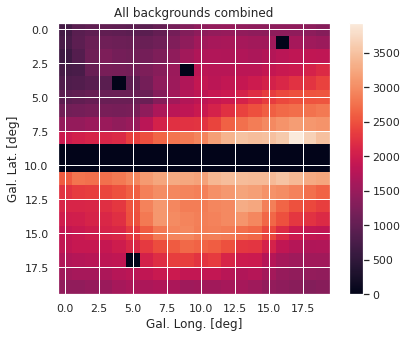

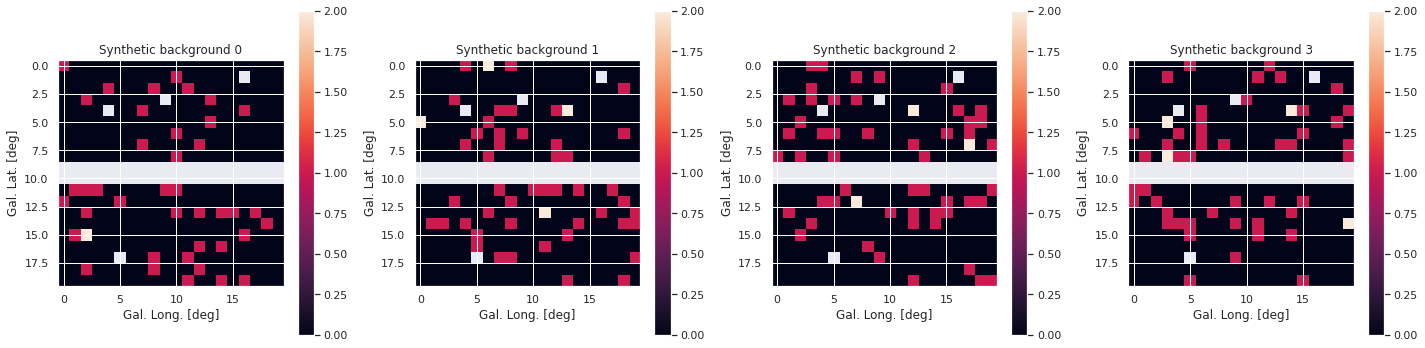

In [ ]:
all_backgrounds = [Ics_ring_1_template, Ics_ring_2_template, Ics_ring_3_template, Ics_ring_4_template,
                GCE_ring_1_template, GCE_ring_2_template, GCE_ring_3_template, GCE_ring_4_template, fermi_template]
signal_conv = signal_templates[injection_spectra]
all_backgrounds = np.array(all_backgrounds)


def random_counts_with_signal(signal_strength,sigma, all_backgrounds, signal_conv):
  count_matrix = np.zeros(signal_conv.shape)
  for mapn in all_backgrounds:
    after_norm = np.random.normal(1, sigma) * mapn
    after_norm = after_norm.clip(0)
    count_matrix += after_norm
  signal_norm = signal_conv * signal_strength
  count_matrix += signal_norm

  count_matrix = np.random.poisson(count_matrix)

  return count_matrix

all_simulated_background = []
for ss in signal_strengts:
  list_MC = []
  for _ in range(MC_times):
    a = random_counts_with_signal(ss,sigma, all_backgrounds, signal_conv)
    list_MC.append(np.ma.array(a, mask=mask2))
  all_simulated_background.append(list_MC)



#all_simulated_background = np.array(all_simulated_background)
sns.set()

## PLotting an example
fig,ax = plt.subplots(figsize = (7,5))
a = ax.imshow(np.sum(all_backgrounds, axis = 0)[0])
ax.set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'All backgrounds combined')
fig.colorbar(a, ax = ax)
plt.show()

fig,ax = plt.subplots(1,4,figsize = (20,5))

for i in range(4):
  a = ax[i].imshow(all_simulated_background[0][i][-1])
  ax[i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Synthetic background {i}')
  fig.colorbar(a, ax = ax[i])

fig.tight_layout()

plt.show()



#The bin by bin analysis class

In [ ]:
class analysis:

  def __init__(self, signal_strength, model_backgrounds,signal1,data_map):
    self.signal_strength = signal_strength
    self.counts_m = data_map
    self.all_backgrounds = model_backgrounds
    self.signal_conv = signal1
    self.signal1 = signal1
    self.sigma = sigma
    self.energy_bin =  energy_bin
    self.variance = np.std(data_map)**2


  def L0_model_long(self, params):
    """
    The background only model: H0
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a]
    return tot_back
    

  def L1_model_long(self, params):
    """
    The background plus signal model: H1
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a]
    
    tot_back += params[-1] * self.signal1
    
    return tot_back


  
  def lik0(self,params):
    """
    Function that computes the likelihood for a given set of parameters  of the background only model
    """
    counts = self.counts_m
    counts_model = self.L0_model_long(params)

    li = np.sum((counts - counts_model)**2) / self.variance
    return 0.5*li



  def lik1(self,params):
    """
    Function that computes the likelihood for a given set of parameters of the background + signal model
    """
    p_sum = 0
    counts = self.counts_m
    counts_model = self.L1_model_long(params)

    li = np.sum((counts - counts_model)**2) / self.variance
    return 0.5*li
  
  def Test_stat(self):
    init_gues0 = [1 for __ in range(len(self.all_backgrounds))]
    init_gues1 = [1 for __ in range(len(self.all_backgrounds))]
    range0 = (0, 10)
    range1 = (0, 10)
    limit_list1 = [range0 for __ in range(len(self.all_backgrounds))]
    limit_list2 = [range1 for __ in range(len(self.all_backgrounds))]
    limit_list2.append((0, None))
    init_gues1.append(self.signal_strength)
    m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.01, limit= limit_list1, errordef=0.5)
    m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.01, limit= limit_list2, errordef=0.5)
    c = m_0.migrad() 
    d = m_1.migrad()
    a = -m_0.fval 
    b = -m_1.fval
    T = -2*(a-b)
    return T, c,d,m_0,m_1

# Doing the analysis

## One energy bin

This is for 1 energy bin, so L1 has 1 additional degree of freedom

In [ ]:
local_T = []
local_check = []
local_check2 = []
energy_bin = 3
signal_bin = 0
for MC in tqdm(range(MC_times)):                 ### Monte carlo analysis


  model_backgrounds = np.array([Ics_ring_1_template[energy_bin], Ics_ring_2_template[energy_bin],  Ics_ring_3_template[energy_bin], Ics_ring_4_template[energy_bin],
                                GCE_ring_1_template[energy_bin], GCE_ring_2_template[energy_bin], GCE_ring_3_template[energy_bin], GCE_ring_4_template[energy_bin], fermi_template[energy_bin]])

  signal1 = signal_templates[injection_spectra][energy_bin]
  data_map = all_simulated_background[signal_bin][MC][energy_bin]

  M = analysis(ss, model_backgrounds,signal1,data_map)
  T, c,d,m_0,m_1 = M.Test_stat()

#    if d.fmin.is_valid == True and c.fmin.is_valid == True:
#      good_T_values.append(T)
#    else:
#      bad_T_values.append(T)
  local_T.append(T)
  local_check.append(d)
  local_check2.append(c)



In [ ]:
all_good_T = []

for e in range(len(local_check)):
  if local_check[e].fmin.is_valid and local_check2[e].fmin.is_valid:
    all_good_T.append(local_T[e])

print (len(all_good_T))

2894


## Hypotheses 0

In [ ]:
local_check2[15]

------------------------------------------------------------------
| FCN = 0.177                   |     Ncalls=514 (514 total)     |
| EDM = 3.53e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |     1     |     7     |            |            |    0    |   10    |       |
| 1 | x1   |     1     |     5     |            |            |    0    |   10    |       |
| 2 | x2   |     0     |     8     |            |            |    0    |   10    |       |
| 3 | x3   |     1     |     5     |            |            |    0    |   10    |       |
| 4 | x4   |     2     |     5     |            |            |    0    |   10    |       |
| 5 | x5   |     1     |     5     |            |            |    0    |   10    |       |
| 6 | x6   |     1     |     9     |            |            |    0    |   10    |       |
| 7 | x7   |     1     |     9     |            |            |    0    |   10    |       |
| 8 | x8   |   0.97    |   0.06    |            |            |    0    |   10    |       |
------------------------------------------------------------------------------------------

## Hypotheses 1

In [ ]:
local_check[15]

------------------------------------------------------------------
| FCN = 0.1776                  |     Ncalls=418 (418 total)     |
| EDM = 1.94e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |     1     |     5     |            |            |    0    |   10    |       |
| 1 | x1   |    1.0    |    1.8    |            |            |    0    |   10    |       |
| 2 | x2   |     1     |     5     |            |            |    0    |   10    |       |
| 3 | x3   |     1     |     5     |            |            |    0    |   10    |       |
| 4 | x4   |    1.5    |    2.9    |            |            |    0    |   10    |       |
| 5 | x5   |    0.9    |    1.9    |            |            |    0    |   10    |       |
| 6 | x6   |     1     |     5     |            |            |    0    |   10    |       |
| 7 | x7   |     1     |     5     |            |            |    0    |   10    |       |
| 8 | x8   |   0.97    |   0.05    |            |            |    0    |   10    |       |
| 9 | x9   |    0.0    |    0.7    |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

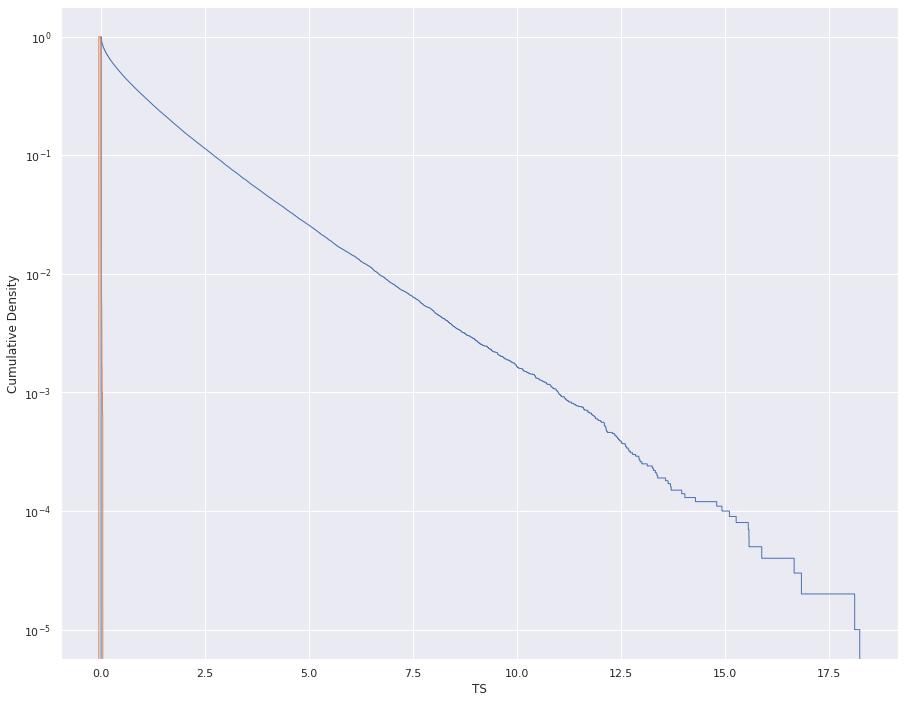

In [ ]:
plt.figure(figsize=(15,12))

r = scipy.stats.chi2.rvs(1,size=100000)

plt.hist(r,histtype='step',bins = 10000,density=1, label = r'chi^2', cumulative=-1)
plt.hist(local_T,histtype='step',bins = 10000,density=1, label = "TS distribution", cumulative=-1)

plt.ylabel('Cumulative Density')
plt.xlabel('TS')

plt.yscale('log')
plt.show()



In [ ]:
a = [i for i in local_T if i > 0]

np.sort(a)

array([2.08356665e-11, 3.29771765e-11, 4.95319341e-11, ...,
       2.06361639e-02, 2.21742631e-02, 1.81412566e-01])